# Organizing, Subsetting and Processing Data

Now that you've successfully downloaded the GRACE and GLDAS data, you will need to read in and process the data to get groundwater anamoly estimates. Both datasets have raw data contained in .nc or .nc4 files. These are files for storing multi-dimensional data--in our case, the key dimensions we are interested in are latittude and longitude (geography) and time. We can use the `xarray` package to read in these data. 

## Reading in GRACE and GLDAS Data

Both datasets have similar processes for loading in the data which are outlined in detail below. However, the first step for processing both datasets is to filter to your region of interest. This is also important because it makes processing times for each step much quicker. As such, our first step in processing will be loading in a shapefile and filtering to the region of interest before loading in GRACE and GLDAS and merging them with other datasets. 

### Subsetting The Data 

For most use cases, it will make the most sense to load in a shapefile and use this file to narrow down your region. This will allow your analysis to focus on your area of interest as precisely as possible and improve the efficiency of your code. If you don't have a shapefile or know your region of interest, you can pick any 4 latitude/longitude points and use them to draw a rectangle around a region of the world you are interested in. You can also skip this step, but note it will make the code take much longer to run. 

For our analysis here, we will use a shapefile that focuses on the Colorado River Basin. 

#### What is a Shapefile? 

A shapefile is a file that stores geometric location and attribute information of geographical features in a nontopological way. Shapefiles represent geographical features by points, lines, or polygons (geographical areas) (ArcGIS). It is one of the simpler ways to store and work with geographic data. Many shapefiles are publicly available for download by government agencies, researchers, or practitioners. Below is an example of what a shapefile looks like in tabular form and how you can go from that to a map.

<img src='/images/shape%20file%20figure.png'>
Source: ReStore

#### Applying This Method to the CRB 

Below, we use this method to use a shapefile of the Colorado River Basin for analysis. You can download the shape file for the Colorado River Basin from ArcGIS hub [here](https://coloradoriverbasin-lincolninstitute.hub.arcgis.com/datasets/colorado-river-basin-hydrological-boundaries-with-areas-served-by-colorado-river/explore?location=36.244092%2C-110.573590%2C6.00). A visual of this is shown below: 

<img src='/images/shape file figure.png'>

To work with shapefiles, we will use the `geopandas` package, a spatial analysis package built on top of `pandas`. We will begin by loading in this package and reading in the shapefile. Next, we will load in plotting functions from `matplotlib` and map the shapefile. 

<Figure size 1000x1000 with 0 Axes>

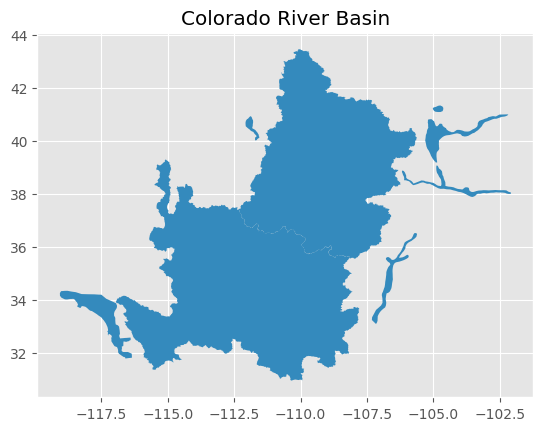

In [12]:
import geopandas as gpd 
import matplotlib.pyplot as plt

shpfl = gpd.read_file("/home/kmk58/remoteData/shapefiles/Colorado_River_Basin_Hydrological_Boundaries_with_Areas_served_by_Colorado_River.shp")

# plot of entire Colorado River Basin
plt.style.use('ggplot')
plt.figure(figsize=[10,10])
shpfl.plot()
plt.title("Colorado River Basin")
plt.show()

A simple way to start narrowing down to the area within the Colorado River Basin is to construct a rectangle around the region and only read in and process rows within that rectangle: 

<p align="left">
    <img src="images/CRB%20rectangle.jpg" width="600" />
</p>

As you can see from the image above, a substantial amount of geography that is not within the CRB is still in the rectange. We will use spatial processes to eliminate those from our dataset later in the process. For now though, focusing on this rectangle will greatly speed up reading and applying other transformations to the data. 

The code to do this is provided below. 

In [13]:
# Code to filter to shapefile

# extract a dataframe of the coordinates from the shapefile
coords = shpfl.get_coordinates()
# find the maximum and minimum lat/longs, corresponding to the red points on the figure above
lon_min = min(coords['x'])
lon_max = max(coords['x'])
lat_min = min(coords['y'])
lat_max = max(coords['y'])

### GRACE

The GRACE MASCON data is contained in 1 .nc file and contains global land MASCON GRACE data. We start by using `xarray` to read in the data. 

In [14]:
import xarray as xr
import os

os.environ['HDF5_USE_FILE_LOCKING']='FALSE'

In [21]:
# Need to change this to relative path later
grace = xr.open_dataset("/home/kmk58/remoteData/GRACE_MASCON/data/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06.1_V3/GRCTellus.JPL.200204_202304.GLO.RL06.1M.MSCNv03CRI.nc") 

In [22]:
# transforming to dataframe and sleecting relevant vars
grace_df = grace[['lon','lat','time','lwe_thickness','uncertainty','scale_factor']].to_dataframe()
grace_df.reset_index(inplace=True)

#subsetting to rectangle containing the Colorado River Basin: GRACE
grace_df["lon"] = grace_df["lon"] - 180  # converting longitude points

grace_df = grace_df[(grace_df.lon> lon_min) & (grace_df.lon < lon_max)]
grace_df = grace_df[(grace_df.lat> lat_min) & (grace_df.lat < lat_max)]


First, since the data is an xarray dataset, we can do some processing to transform the dataset into a standard tabular, pandas dataframe. For efficiency, we can also only select the variables we need, and for use with other datasets, we will transform the longitude points from a [0,360] range to a [-180,180] range.  

In [23]:
# Need to figure out what to do about the NaNs
grace_df.sort_values(by='time', inplace=True)
grace_df['new_lwe'] = grace_df['lwe_thickness'] * grace_df['scale_factor']
grace_df

,lon,lat,time,lwe_thickness,uncertainty,scale_factor,new_lwe
9715640,-118.75,31.25,2002-04-17 12:00:00,1.135869,2.638984,1.603936,1.821861
11458480,-107.75,32.25,2002-04-17 12:00:00,7.364322,14.865509,0.509262,3.750371
11458700,-107.75,32.75,2002-04-17 12:00:00,7.364322,14.865509,0.509262,3.750371
11458920,-107.75,33.25,2002-04-17 12:00:00,7.364322,14.865509,0.682281,5.024540
11459140,-107.75,33.75,2002-04-17 12:00:00,7.364322,14.865509,0.682281,5.024540
...,...,...,...,...,...,...,...
11460019,-107.75,35.25,2023-04-16 00:00:00,-6.318313,8.447631,1.251672,-7.908456
11459799,-107.75,34.75,2023-04-16 00:00:00,-6.318313,8.447631,0.990343,-6.257299
11459579,-107.75,34.25,2023-04-16 00:00:00,-21.944085,6.949303,1.469034,-32.236599
11538559,-107.25,33.75,2023-04-16 00:00:00,-21.944085,6.949303,0.682281,-14.972040


The first thing you will note is that the dataset has several dimensions: `lon`, `lat`, `time`, and `bounds`. This is because the GRACE data come at the pixel-level for each year. In our sitution, a pixel is the smallest geographic unit of analysis. Because collecting and processing GRACE satellite data is technical and compuationally expensive, GRACE measurements are given as .5-degree by .5-degree squares. The pixels cover the entire Earth's surface and each have a GRACE measurement monthly from 2003-present. A visual of this is shown below, where each square in the GRID correponds to a pixel (Sharma, Patnaik, Biswal, Reager, 2020). Note that the yellow dots are gauging stations for comparison. 

<p align="center">
    <img src="images/GRACE_grids.png" width="500" />
</p>

### GLDAS Data 

Next, we will read in the GLDAS data which provides us with information on snow pack and soil moisture. These data are similarly in a multidimensional data format which can be read in using `xarray`. However, the data come in individual files that require being read in and combined into one dataset. The code below does this. 

In [25]:
### there must be some way to make this code run faster. Maybe do all the filtering before you make it into DF. 

import pandas as pd

gl_path = "/home/kmk58/remoteData/GLDAS/NOAH_monthly_L4/"

gl_df = pd.DataFrame()
itera = 0

#Iterating through files in path
for filename in os.listdir(gl_path):
    
    if filename.endswith(".nc4"):
        
        #Reading in data as xarray then converting to DataFrame
        xd = xr.open_dataset(gl_path+str(filename))
        xd_df = xd.to_dataframe()

        xd_df.reset_index(inplace=True)

        xd_df = xd_df[(xd_df.lon> lon_min) & (xd_df.lon < lon_max)]
        xd_df = xd_df[(xd_df.lat> lat_min) & (xd_df.lat < lat_max)]

        #Extracting only needed columns 
        df_slice = xd_df[["time", "lon", "lat", "SWE_inst", 'SoilMoi0_10cm_inst',
           'SoilMoi10_40cm_inst', 'SoilMoi40_100cm_inst', 'SoilMoi100_200cm_inst']]
        df_slice = df_slice.dropna()

        gl_df = pd.concat([gl_df, df_slice], axis=0)
        itera+=1

As you can see from the output above, the shapefile is mapped with lattitude on the x-axis and longitude on the y-axis. We can easily discern the area of the Colorado River Basin. 

Our next step is to filter the GRACE and GLDAS data to the CRB region before merging and processing the data. There are a few steps involved with this: 

1. We must extract a list of latitude and longitude coordinates for the CRB 
2. We must filter GRACE down to points only contained in this file 
3. We must filter GLDAS down to points only contained in this file. 

In [26]:
gdf = grace_df[["lon","lat"]]

gdf_points = gpd.GeoDataFrame(gdf, 
                              crs='epsg:4326',
                              geometry=gpd.points_from_xy(gdf['lon'],
                                                          gdf['lat']))

In [27]:
# this takes long 

grace_df = pd.DataFrame()
itera = 0

for sh in shpfl["geometry"]:
    temp_df = grace_df[gdf_points.intersects(sh)]
    grace_df = pd.concat([grace_df,temp_df])
    
    itera+=1

/tmp/ipykernel_4144683/3866525041.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp_df = grace_df[gdf_points.intersects(sh)]
/tmp/ipykernel_4144683/3866525041.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp_df = grace_df[gdf_points.intersects(sh)]
/tmp/ipykernel_4144683/3866525041.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp_df = grace_df[gdf_points.intersects(sh)]
/tmp/ipykernel_4144683/3866525041.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp_df = grace_df[gdf_points.intersects(sh)]
/tmp/ipykernel_4144683/3866525041.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp_df = grace_df[gdf_points.intersects(sh)]
/tmp/ipykernel_4144683/3866525041.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp_df = grace_df[gdf_points.intersects(sh)]


##### Upsampling GRACE

One key consideration for combining GRACE and GLDAS data is that pixels in GRACE data are .5°x.5° while GLDAS data has .25°x.25° pixels. One way to handle this is to "upscale" GRACE data to make it mergable with GLDAS. That is, transform the GRACE data pixels from .5°x.5° to .25°x.25°. 

One way we can do this is to "upsample" GRACE data. Essentially, we will 

This is shown visually below: 

Finally, we implement this in code: 

In [15]:
## also feel like we can do something to make this run faster. 

import collections
import pandas as pd

up_gr_df = pd.DataFrame()

for t in collections.Counter(grace_df["time"]).keys():
    
    sub_df_gr = grace_df[grace_df["time"] == t]
    #print(t)
    
    for x,y in zip(sub_df_gr["lon"], sub_df_gr["lat"]):
                
        xx = [round(x-0.125,3), round(x+0.125,3)] 
        yy = [round(y-0.125,3), round(y+0.125,3)]
        
        val_df = sub_df_gr[(sub_df_gr["lon"]==x)&(sub_df_gr["lat"]==y)]

        temp_df = pd.DataFrame()
                    
        temp_df["time"] = [t]*4
        temp_df["lon"] = [xx[0],xx[0],xx[1],xx[1]]
        temp_df["lat"] = [yy[0],yy[1],yy[0],yy[1]]
        temp_df["lwe_thickness"] = [val_df["lwe_thickness"].mean()]*4

        up_gr_df = pd.concat([up_gr_df,temp_df])

 After "upsampling" the GRACE data, it now also has a .25° by .25° granularity. Each "pixel" thus represents a chunk of land approximately 235.46 miles squared ($\approx$ 378.94 kilometers squared). A visualizaiton of a pixel is shown below.

<p align="center">
    <img src="images/lon-lat.png" width="500" />
</p>

### Merging the Datasets 

Now that GRACE and GLDAS are in standardized, tabular formats, we can merge these datasets together to combine all the variables of interest and calculate groundwater estimates. We perform a left join merging GLDAS to GRACE data, since GRACE data is already filtered to the area of interest. 

In [81]:
from datetime import datetime

up_gr_df['time'] = [datetime.strptime(str(t)[0:7], '%Y-%m') for t in up_gr_df["time"]]
gl_df["time"] = [datetime.strptime(str(t)[0:7], '%Y-%m') for t in gl_df["time"]]

gw_final_df = up_gr_df.merge(gl_df, on=["time", "lat", "lon"], how="left")

### Generating Groundwater Anamolies 

In order to compute groundwater anamolies, you need to compute the deviation from the mean ($d_i$) for each measurement ($p_i$). That is: 

$d_i = p_i - \mu$ 

In order to calculate $\mu$, you take the average for each water category over a specified time period. Here, we use the time period from 2004-2009, following NASA and recent literature, which is shown in code below. Note that the code is easily modifiable if you would like to focus on a different time period. 


In [82]:
from datetime import timedelta

start_date = datetime.strptime("2004-01-01", "%Y-%m-%d")
end_date = datetime.strptime("2009-12-01", "%Y-%m-%d")

base_line_dates = pd.date_range(start_date, end_date,freq='M',unit="s")
base_line_dates = base_line_dates + timedelta(days=1)

In [83]:
baseline_df = gw_final_df[gw_final_df['time'].isin(base_line_dates)]

swe_mean = baseline_df['SWE_inst'].mean()
sm_mean = baseline_df['SoilMoi0_10cm_inst'].mean()


In [84]:
gw_final_df['d_SWE_inst'] = gw_final_df['SWE_inst'] - swe_mean
gw_final_df['d_SoilMoi0_10cm_inst'] = gw_final_df['SoilMoi0_10cm_inst'] - sm_mean

In [94]:
gw_final_df['gw_estimate'] = .1*(gw_final_df['lwe_thickness'] - (gw_final_df['d_SWE_inst'] + gw_final_df['d_SWE_inst']))

Congratulations. You have just constructed a dataset with groundwater anamoly estimates for each pixel in the Colorado River Basin. Now, we can move on to the next notebook where we can visualize this output. 

In [99]:
gw_crb = gw_final_df[['time','gw_estimate']]
gw_crb = gw_crb.groupby(['time']).mean().reset_index()

,time,gw_estimate
0,2002-04-01,0.755476
1,2002-05-01,1.298583
2,2002-08-01,0.129697
3,2002-09-01,-0.224243
4,2002-10-01,-0.598291
...,...,...
213,2022-12-01,-2.142262
214,2023-01-01,-4.565136
215,2023-02-01,-4.600987
216,2023-03-01,-4.321993


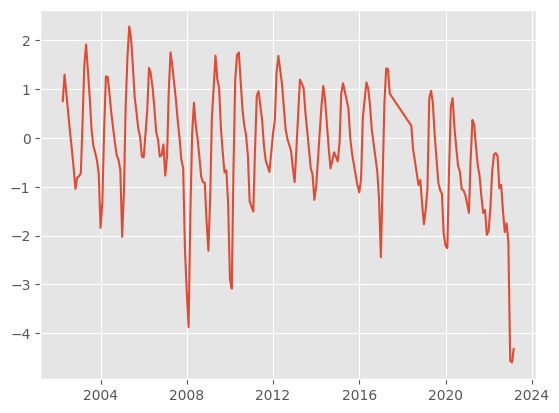

In [100]:
import matplotlib.pyplot as plt

plt.plot('time', 'gw_estimate', data=gw_crb)
plt.show()

## Citations

(Sharma D, Patnaik S, Biswal B, Reager JT. Characterization of Basin-Scale Dynamic Storage–Discharge Relationship Using Daily GRACE Based Storage Anomaly Data. Geosciences. 2020; 10(10):404. https://doi.org/10.3390/geosciences10100404). 

Merging shapefiles in ArcGIS. (n.d.). Retrieved July 24, 2023, from https://www.restore.ac.uk/geo-refer/91010mwors01y00000000.php


